In [106]:
library(survey)
library(effsize)
library(dplyr)
library(ggplot2)
library(tableone)

In [ ]:
dfCrime = read.csv("crime_v2.csv")

In [121]:
# summary(dfCrime)

In [11]:
summary(dfCrime[is.na(dfCrime),])

dfCrime <-na.omit(dfCrime) # get rid of the NA rows

In [12]:
dfCrime[duplicated(dfCrime),]

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
89,193,87,0.0235277,0.266055,0.588859022,0.423423,5.86,0.00117887,0.8138298,28.51783,⋯,480.1948,268.3836,365.0196,295.9352,295.63,468.26,337.88,348.74,0.1105016,0.07819394


In [13]:
dfCrime <- dfCrime[!duplicated(dfCrime),] # get rid of the duplicated row

In [14]:
dfCrime$prbconv<-as.numeric(levels(dfCrime$prbconv))[dfCrime$prbconv]

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [15]:
dfCrime$county<-as.factor(dfCrime$county) #note that we're missing 10 counties from NC; 6 were blank rows in this set, one row was a duplicate

In [18]:
dfCrime$pctmin80<-dfCrime$pctmin80/100 # units are off in comparison to pctymle; we either divide by 100 here or multiply the other one

In [16]:
#Map central and west to a region code.
# Note that county 71 has both western and central codes
dfCrime$region <- case_when (
            (dfCrime$central ==0 & dfCrime$west ==0) ~ 0, #Eastern, Coastal, Other
            (dfCrime$central ==0 & dfCrime$west ==1) ~ 1, #Western
            (dfCrime$central ==1 & dfCrime$west ==0) ~ 2, #Central
            (dfCrime$central ==1 & dfCrime$west ==1) ~ 3, #Central-Western border county - this could be Charlotte or it could be a coding error.
        )

In [17]:
# create a factor for 'central', 'western', 'central/western' and 'eastern, coastal, other' region
dfCrime$region =
            factor( dfCrime$region , levels = 0:3 , labels =
                    c( 'Region 1',
                       'Region 2',
                       'Region 3',
                       'Region 4'
                      )
                   )

In [78]:
# create factor for SMSA (standard metropolitan statistical areas) with two levels - inside or outside
#    https://www2.census.gov/prod2/decennial/documents/1980/1980censusofpopu8011uns_bw.pdf
dfCrime$metro =
            factor( dfCrime$urban , levels = 0:1 , labels =
                    c( 'Outside',
                       'Inside'
                      )
                   )

In [83]:
# 8 counties are inside a metro area. 82 are outside a metro area.
table(dfCrime$urban)


 0  1 
82  8 

In [85]:
# create a crime index (number of crimes per square mile in the county) to remove causal effects with the population density
#   crmrte = crimes committed per person
#   density = people per sq. mile, in 100s (through analysis with our EDA and confirmation on US census 1980 report)

dfCrime$crmidx = dfCrime$crmrte * dfCrime$density * 100

In [22]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)
# dfCrime %>% arrange(desc(crmrte))

In [23]:
# dfCrime %>% filter(crmrte<1) %>% arrange(desc(wser))
#Note wser for county 185 is probably a coding error. It is a huge outlier.

In [99]:
options(repr.plot.width=6, repr.plot.height=4)

In [100]:
# 'county', 'year', 'crmrte', 'prbarr', 'prbconv', 'prbpris', 'avgsen', 'polpc', 'density', 'taxpc', 'west', 'central', 'urban', 'pctmin80', 'mix','pctymle' 
# 15     wcon|       weekly wage, construction
# 16     wtuc|    wkly wge, trns, util, commun
# 17     wtrd| wkly wge, whlesle, retail trade
# 18     wfir|    wkly wge, fin, ins, real est
# 19     wser|      wkly wge, service industry
# 20     wmfg|         wkly wge, manufacturing
# 21     wfed|         wkly wge, fed employees
# 22     wsta|       wkly wge, state employees
# 23     wloc|        wkly wge, local gov emps

# install.packages("reshape2")
library(reshape2)



dfCrimeWages = melt(dfCrime, 
                    id.var = c('county', 'year', 'crmrte', 'prbarr', 
                                        'prbconv', 'prbpris', 'avgsen', 'polpc', 
                                        'density', 'taxpc', 'west', 'central', 
                                        'urban', 'pctmin80', 'mix','pctymle', 
                                        'region', 'metro'), 
                    variable.name = 'wage_industry'
                   )
colnames(dfCrimeWages)[colnames(dfCrimeWages)=="value"] <- "wage_amnt"
summary(dfCrimeWages$wage_amnt)

# find the outlier for wser. Need to remove. 
bad_one = subset(dfCrimeWages, wage_amnt >= 2177)
# $2177.068 wser

#removes outlier from dataframe
dfCrimeWages = subset(dfCrimeWages, wage_amnt < 2177) 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  133.0   263.2   317.0   328.1   377.9  2177.1 

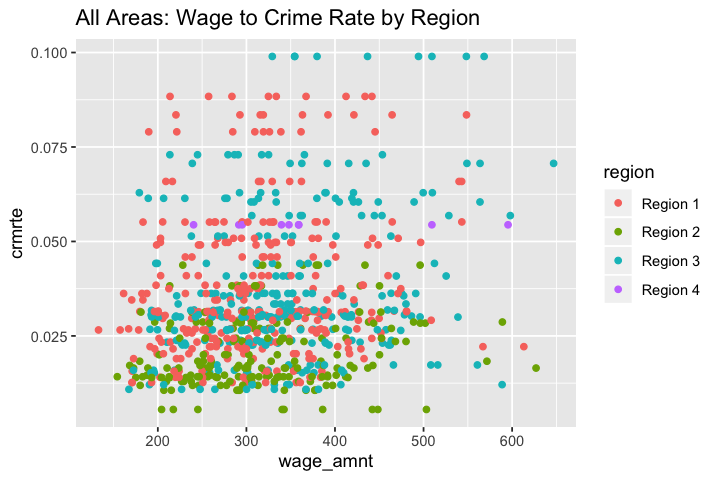

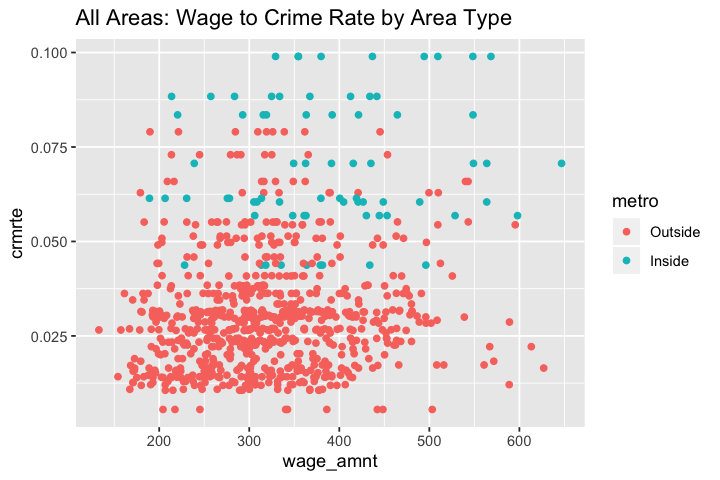

In [127]:
ggplot(data = dfCrimeWages, aes(x = wage_amnt, y = crmrte, color = region)) + ggtitle("All Counties: Wage to Crime Rate by Region") + 
  geom_point() 


ggplot(data = dfCrimeWages, aes(x = wage_amnt, y = crmrte, color = metro)) + ggtitle("All Counties: Wage to Crime Rate by Area Type") +  
  geom_point() 

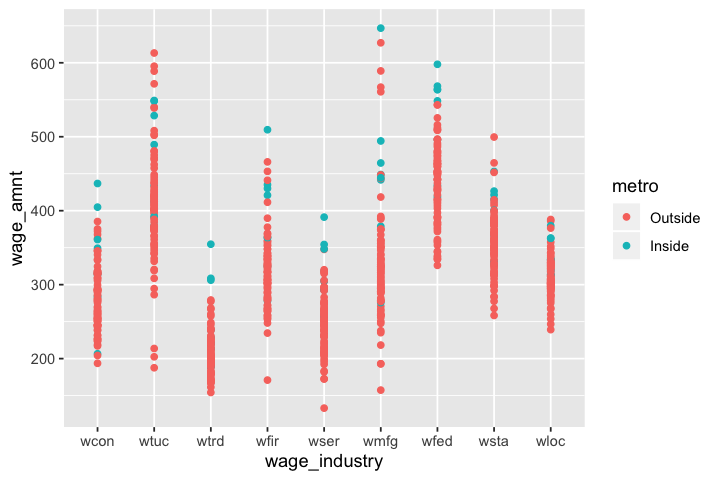

In [128]:
ggplot(data = dfCrimeWages, aes(x = wage_industry, y = wage_amnt, color = metro)) +
  geom_point() 

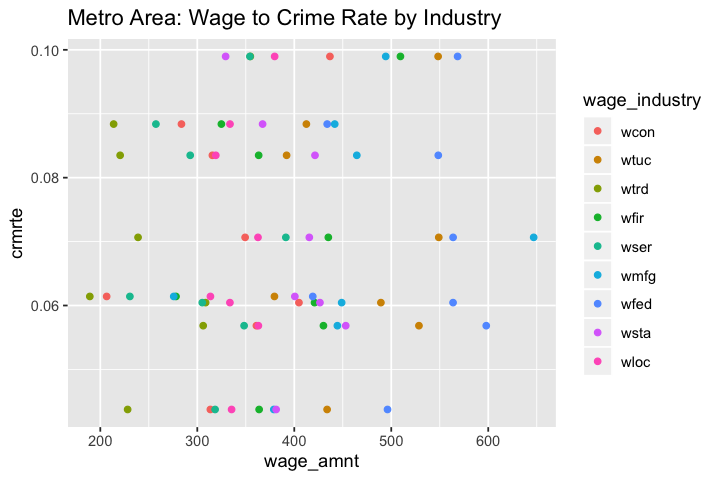

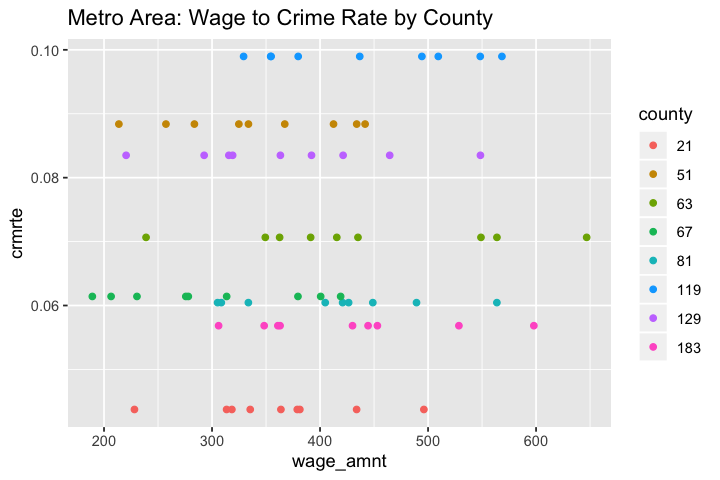

In [120]:
dfCrimeWages_InsideMetro = subset(dfCrimeWages, metro == 'Inside')

ggplot(data = dfCrimeWages_InsideMetro, aes(x = wage_amnt, y = crmrte, color = wage_industry)) + ggtitle("Metro Area: Wage to Crime Rate by Industry") + geom_point() 

ggplot(data = dfCrimeWages_InsideMetro, aes(x = wage_amnt, y = crmrte, color = county)) + ggtitle("Metro Area: Wage to Crime Rate by County") + 
  geom_point() 

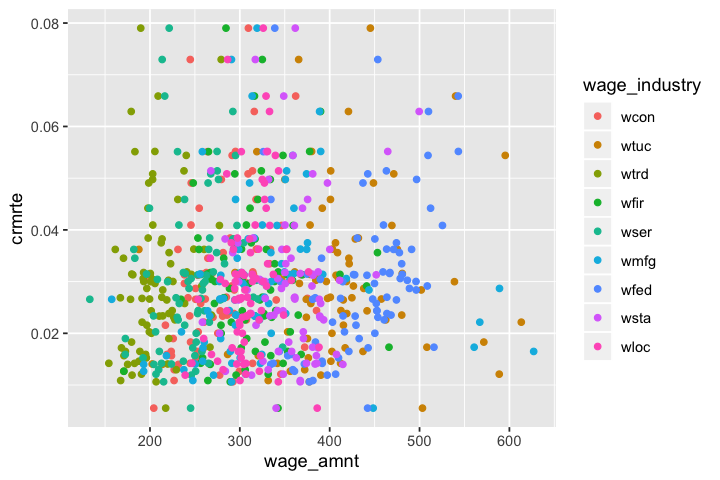

In [90]:
dfCrimeWages_OutsideMetro = subset(dfCrimeWages, metro == 'Outside')

ggplot(data = dfCrimeWages_OutsideMetro, aes(x = wage_amnt, y = crmrte, color = wage_industry)) + 
  geom_point()  

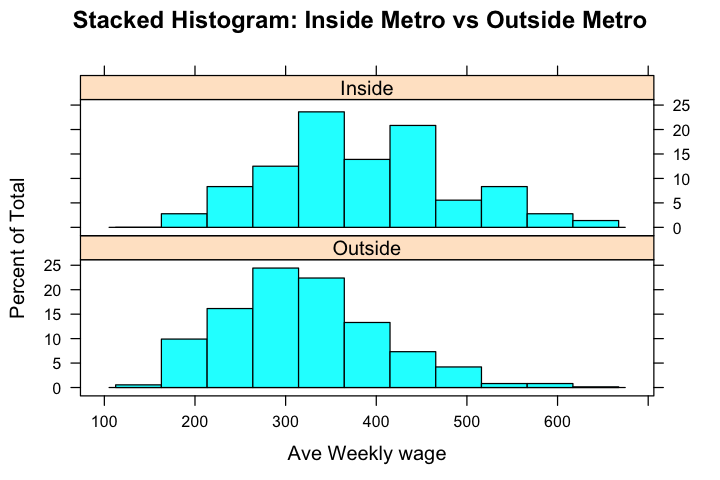

In [95]:
# install.packages("lattice") # install the package
# library(lattice) # load the library after installing
 
histogram(data = dfCrimeWages, ~wage_amnt|metro, layout = c(1,2), #stacked histogram
main = "Stacked Histogram: Inside Metro vs Outside Metro",
xlab = "Ave Weekly wage")

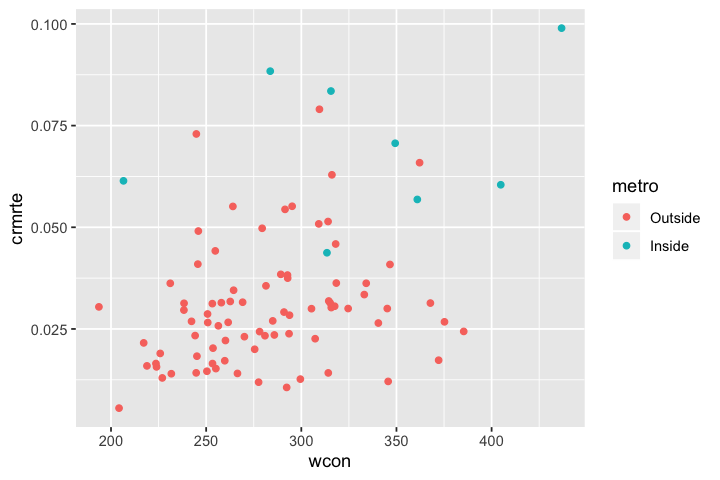

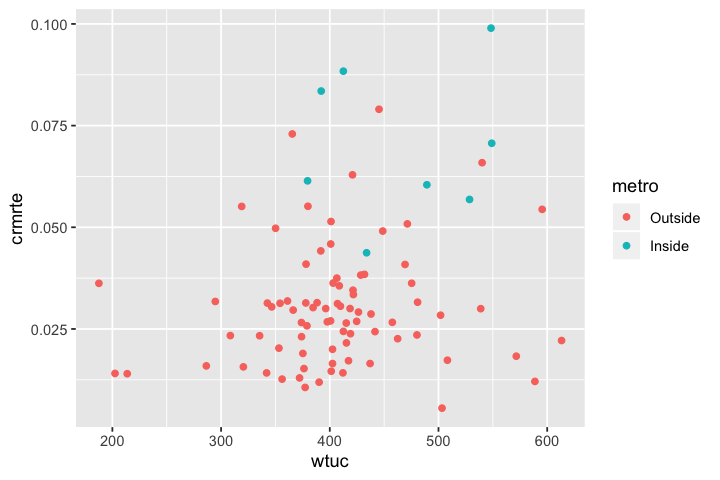

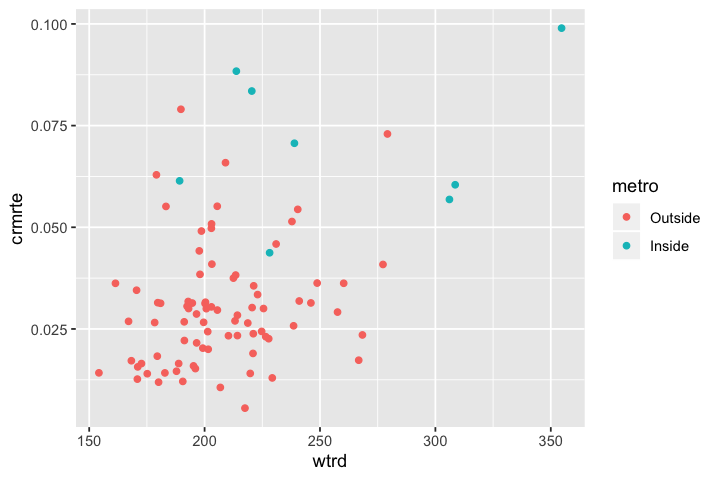

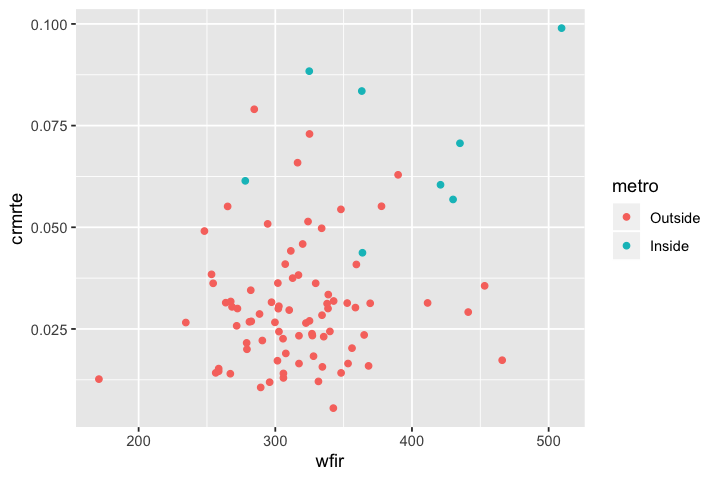

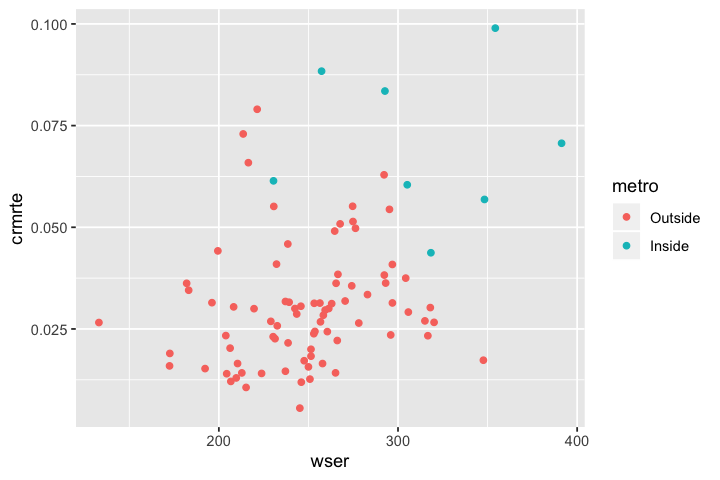

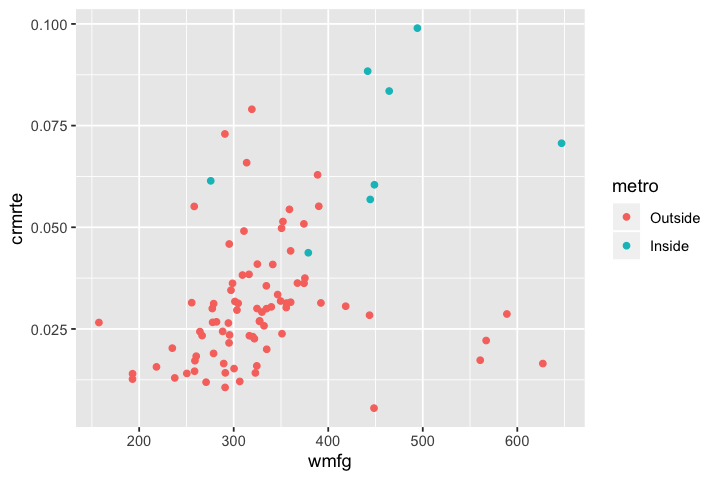

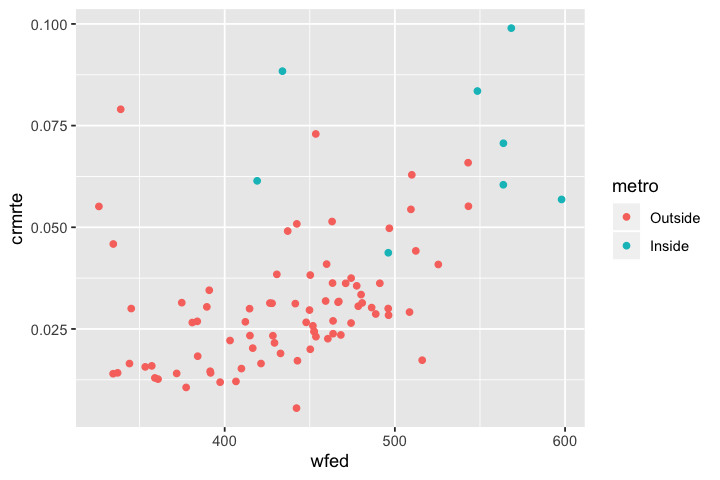

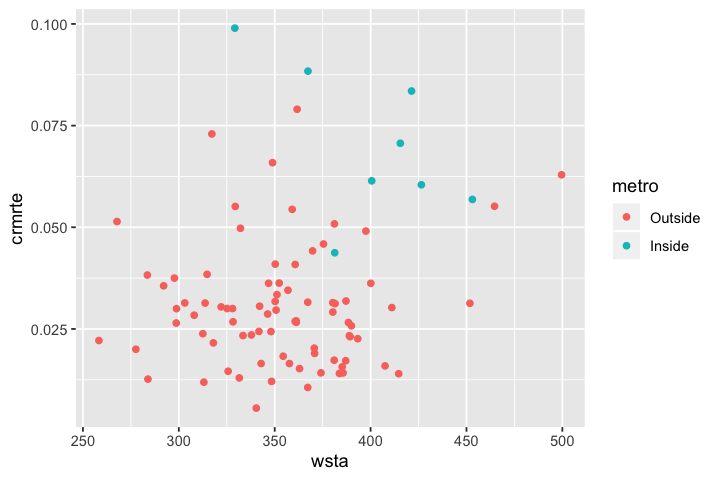

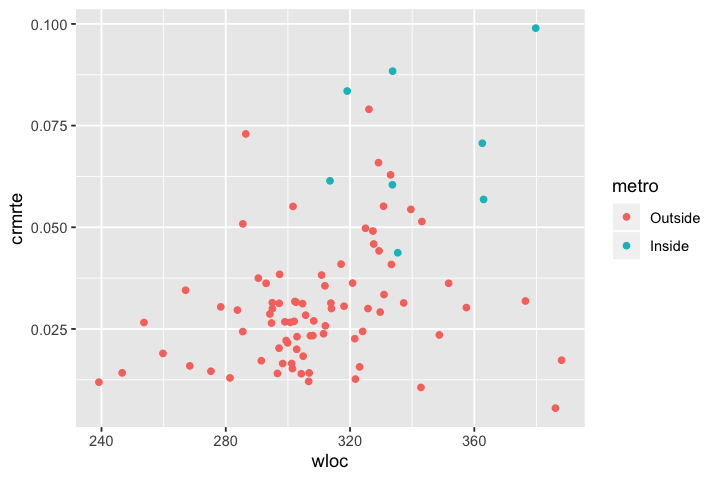

In [103]:

# 15     wcon|       weekly wage, construction
# 16     wtuc|    wkly wge, trns, util, commun
# 17     wtrd| wkly wge, whlesle, retail trade
# 18     wfir|    wkly wge, fin, ins, real est
# 19     wser|      wkly wge, service industry
# 20     wmfg|         wkly wge, manufacturing
# 21     wfed|         wkly wge, fed employees
# 22     wsta|       wkly wge, state employees
# 23     wloc|        wkly wge, local gov emps

dfCrime2 <- subset(dfCrime, wser < 2177)

ggplot(data = dfCrime2, aes(x = wcon, y = crmrte, color = metro)) + 
  geom_point() 

ggplot(data = dfCrime2, aes(x = wtuc, y = crmrte, color = metro)) + 
  geom_point() 

ggplot(data = dfCrime2, aes(x = wtrd, y = crmrte, color = metro)) + 
  geom_point() 

ggplot(data = dfCrime2, aes(x = wfir, y = crmrte, color = metro)) + 
  geom_point() 

ggplot(data = dfCrime2, aes(x = wser, y = crmrte, color = metro)) + 
  geom_point() 

ggplot(data = dfCrime2, aes(x = wmfg, y = crmrte, color = metro)) + 
  geom_point() 

ggplot(data = dfCrime2, aes(x = wfed, y = crmrte, color = metro)) + 
  geom_point() 

ggplot(data = dfCrime2, aes(x = wsta, y = crmrte, color = metro)) + 
  geom_point() 

ggplot(data = dfCrime2, aes(x = wloc, y = crmrte, color = metro)) + 
  geom_point() 


# ggplot(data = dfCrime, 
#        aes(x = wtuc, y = crmrte, color=region)) +
#   geom_boxplot(alpha=.3) + geom_jitter(position=position_jitter(0.2)) + facet_wrap(~ metro)


# ggplot(data = dfCrime, aes(x = density, y = crmrte, color = region)) + 
#   geom_point() +  scale_x_log10() + scale_y_log10()

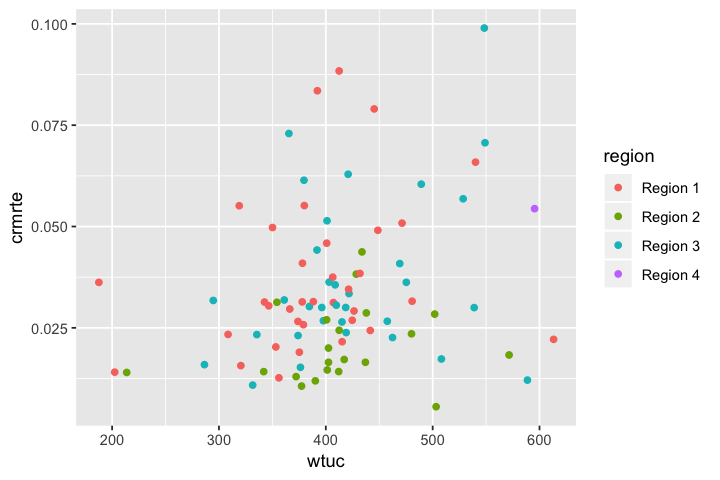

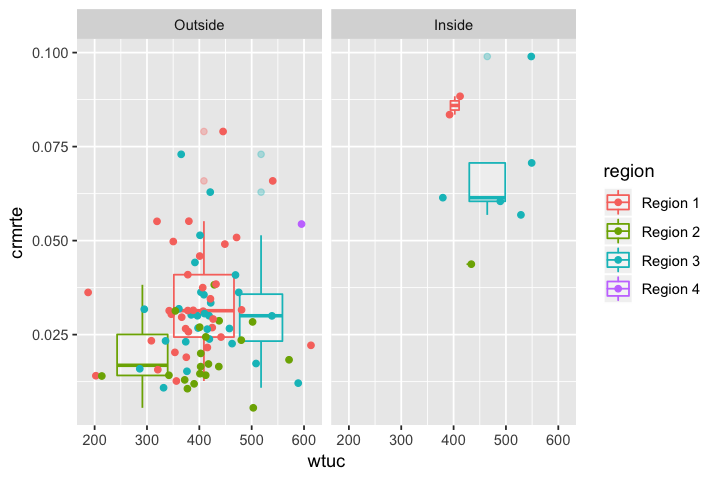

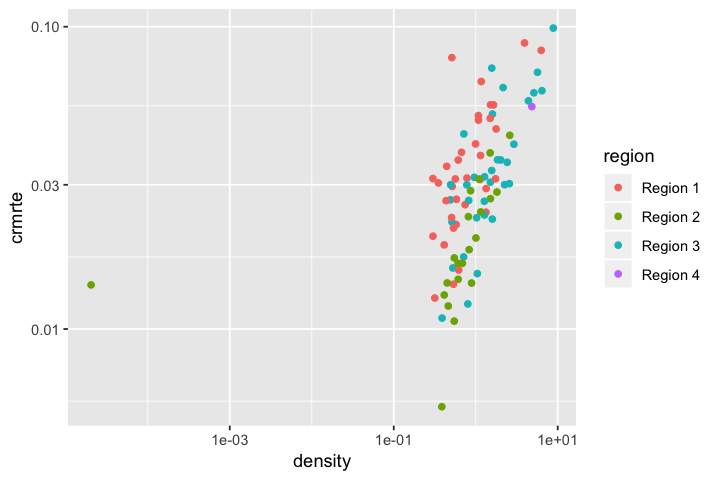

In [90]:
#ggplot(data = dfCrime, aes(x = density, y = crmidx, color = region)) +
#  geom_point()

ggplot(data = dfCrime, aes(x = wtuc, y = crmrte, color = region)) + 
  geom_point() 

ggplot(data = dfCrime, 
       aes(x = wtuc, y = crmrte, color=region)) +
  geom_boxplot(alpha=.3) + geom_jitter(position=position_jitter(0.2)) + facet_wrap(~ metro)


ggplot(data = dfCrime, aes(x = density, y = crmrte, color = region)) + 
  geom_point() +  scale_x_log10() + scale_y_log10()